
# 4.6: Simulate Beta-modulated ERP

This example demonstrates how event related potentials (ERP) are modulated
by prestimulus beta events. Specifically, this example reproduces Figure 5
from (Law et al. 2021). To be consistent with the publication, the default
network connectivity is altered. These modifications demonstrate a potential
mechanism by which transient beta activity in the neocortex can suppress
the perceptibility of sensory input. This suppression depends on the timing
of the beta event, and the incoming sensory information.

In [1]:
# Authors: Nick Tolley <nicholas_tolley@brown.edu>

from hnn_core import simulate_dipole, law_2021_model, jones_2009_model
from hnn_core.viz import plot_dipole

--No graphics will be displayed.


We begin by instantiating the network model from (Law et al. 2021):

In [2]:
net = law_2021_model()

The Law 2021 model is based on the network model described in
(Jones et al. 2009) with several important modifications. One of the most
significant changes is substantially increasing the rise and fall time
constants of GABAb-conductances on L2 and L5 pyramidal. Another important
change is the removal of calcium channels from basal dendrites and soma of
L5 pyramidal cells specifically.
We can inspect these properties with the `net.cell_types` attribute which
contains information on the biophysics and geometry of each cell.

In [3]:
net_jones = jones_2009_model()

jones_rise = net_jones.cell_types['L5_pyramidal'].synapses['gabab']['tau1']
law_rise = net.cell_types['L5_pyramidal'].synapses['gabab']['tau1']
print(f'GABAb Rise (ms): {jones_rise} -> {law_rise}')

jones_fall = net_jones.cell_types['L5_pyramidal'].synapses['gabab']['tau2']
law_fall = net.cell_types['L5_pyramidal'].synapses['gabab']['tau2']
print(f'GABAb Fall (ms): {jones_fall} -> {law_fall}\n')

print('Apical Dendrite Channels:')
print(net.cell_types['L5_pyramidal'].sections['apical_1'].mechs.keys())
print("\nBasal Dendrite Channels ('ca' missing):")
print(net.cell_types['L5_pyramidal'].sections['basal_1'].mechs.keys())

GABAb Rise (ms): 1.0 -> 45.0
GABAb Fall (ms): 20.0 -> 200.0

Apical Dendrite Channels:
dict_keys(['hh2', 'ca', 'cad', 'kca', 'km', 'cat', 'ar'])

Basal Dendrite Channels ('ca' missing):
dict_keys(['hh2', 'cad', 'kca', 'km', 'cat', 'ar'])


A major change to the Jones 2009 model is the addition of a
Martinotti-like recurrent tuft connection (Silberberg and Markram 2007). This new connection
originates from L5 basket cells, and provides GABAa inhibition on
the distal dendrites of L5 pyramidal cells.

In [4]:
print('Recurrent Tuft Connection')
print(net.connectivity[16])

Recurrent Tuft Connection
L5_basket -> L5_pyramidal
cell counts: 35 srcs, 100 targets
connection probability: 1.0 
loc: 'distal'; receptor: 'gabaa'
weight: 0.025; delay: 1.0; lamtha: 70.0
 


The remaining changes to the connectivity was the removal of an
L2_basket -> L5_pyramidal GABAa connection, and replacing it with GABAb.



In [5]:
print('New GABAb connection')
print(net.connectivity[15])

print('\nConnection Removed from Law Model')
print(net_jones.connectivity[10])

New GABAb connection
L2_basket -> L5_pyramidal
cell counts: 35 srcs, 100 targets
connection probability: 1.0 
loc: 'distal'; receptor: 'gabab'
weight: 0.0002; delay: 1.0; lamtha: 50.0
 

Connection Removed from Law Model
L2_basket -> L5_pyramidal
cell counts: 35 srcs, 100 targets
connection probability: 1.0 
loc: 'distal'; receptor: 'gabaa'
weight: 0.001; delay: 1.0; lamtha: 50.0
 


To demonstrate sensory depression, we will add the drives necessary to
generate and ERP similar to our
[ERP example](https://dylansdaniels.github.io/website_redesign/content/05_erps/hnn_core.html),
but modified to reflect the parameters used in (Law et al. 2021).
Specifically, we are considering the case where a tactile stimulus is
delivered at 150 ms. 25 ms later, the first input to sensory cortex arrives
as a proximal drive to the cortical column. Proximal drive corresponds to
projections from the direct thalamic nuclei. This is followed by one
`distal` drive representing projections from indirect thalamic nuclei,
and a final late proximal drive. It is important to note that the parameter
values for each are different from previous examples of the evoked response.
This reflects the altered network dynamics due to the changes described
above.

In [6]:
def add_erp_drives(net, stimulus_start):
    # Distal evoked drive
    weights_ampa_d1 = {'L2_basket': 0.0005, 'L2_pyramidal': 0.004,
                       'L5_pyramidal': 0.0005}
    weights_nmda_d1 = {'L2_basket': 0.0005, 'L2_pyramidal': 0.004,
                       'L5_pyramidal': 0.0005}
    syn_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                     'L5_pyramidal': 0.1}
    net.add_evoked_drive(
        'evdist1', mu=70.0 + stimulus_start, sigma=0.0, numspikes=1,
        weights_ampa=weights_ampa_d1, weights_nmda=weights_nmda_d1,
        location='distal', synaptic_delays=syn_delays_d1, event_seed=274)

    # Two proximal drives
    weights_ampa_p1 = {'L2_basket': 0.002, 'L2_pyramidal': 0.0011,
                       'L5_basket': 0.001, 'L5_pyramidal': 0.001}
    syn_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                       'L5_basket': 1., 'L5_pyramidal': 1.}

    # all NMDA weights are zero; pass None explicitly
    net.add_evoked_drive(
        'evprox1', mu=25.0 + stimulus_start, sigma=0.0, numspikes=1,
        weights_ampa=weights_ampa_p1, weights_nmda=None,
        location='proximal', synaptic_delays=syn_delays_prox, event_seed=544)

    # Second proximal evoked drive. NB: only AMPA weights differ from first
    weights_ampa_p2 = {'L2_basket': 0.005, 'L2_pyramidal': 0.005,
                       'L5_basket': 0.01, 'L5_pyramidal': 0.01}
    # all NMDA weights are zero; omit weights_nmda (defaults to None)
    net.add_evoked_drive(
        'evprox2', mu=135.0 + stimulus_start, sigma=0.0, numspikes=1,
        weights_ampa=weights_ampa_p2, location='proximal',
        synaptic_delays=syn_delays_prox, event_seed=814)

    return net

A beta event is created by inducing simultaneous proximal and distal
drives. The input is just strong enough to evoke spiking in the
L2 basket cells. This spiking causes GABAb mediated inhibition
of the network, and ultimately suppressed sensory detection.



In [7]:
def add_beta_drives(net, beta_start):
    # Distal Drive
    weights_ampa_d1 = {'L2_basket': 0.00032, 'L2_pyramidal': 0.00008,
                       'L5_pyramidal': 0.00004}
    syn_delays_d1 = {'L2_basket': 0.5, 'L2_pyramidal': 0.5,
                     'L5_pyramidal': 0.5}
    net.add_bursty_drive(
        'beta_dist', tstart=beta_start, tstart_std=0., tstop=beta_start + 50.,
        burst_rate=1., burst_std=10., numspikes=2, spike_isi=10,
        n_drive_cells=10, location='distal', weights_ampa=weights_ampa_d1,
        synaptic_delays=syn_delays_d1, event_seed=290)

    # Proximal Drive
    weights_ampa_p1 = {'L2_basket': 0.00004, 'L2_pyramidal': 0.00002,
                       'L5_basket': 0.00002, 'L5_pyramidal': 0.00002}
    syn_delays_p1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                     'L5_basket': 1.0, 'L5_pyramidal': 1.0}

    net.add_bursty_drive(
        'beta_prox', tstart=beta_start, tstart_std=0., tstop=beta_start + 50.,
        burst_rate=1., burst_std=20., numspikes=2, spike_isi=10,
        n_drive_cells=10, location='proximal', weights_ampa=weights_ampa_p1,
        synaptic_delays=syn_delays_p1, event_seed=300)
    return net

We can now use our functions to create three distinct simulations:

1. beta event only, 
2. ERP only, and 
3. beta event + ERP.

In [8]:
beta_start, stimulus_start = 50.0, 125.0
net_beta = net.copy()
net_beta = add_beta_drives(net_beta, beta_start)

net_erp = net.copy()
net_erp = add_erp_drives(net_erp, stimulus_start)

net_beta_erp = net_beta.copy()
net_beta_erp = add_erp_drives(net_beta_erp, stimulus_start)

And finally we simulate. Note that the default simulation time has been
increased to 400 ms to observe the long time course over which beta events
can influence sensory input to the cortical column.



In [9]:
dpls_beta = simulate_dipole(net_beta, tstop=400)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...
Trial 1: 300.0 ms...
Trial 1: 310.0 ms...
Trial 1: 320.0 ms...
Trial 1: 330.0 ms...
Trial 1: 340.0 ms...
Trial 1: 350.0 ms...
Trial 1: 360.0 ms...
Trial 1: 370

In [10]:
dpls_erp = simulate_dipole(net_erp, tstop=400)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...
Trial 1: 300.0 ms...
Trial 1: 310.0 ms...
Trial 1: 320.0 ms...
Trial 1: 330.0 ms...
Trial 1: 340.0 ms...
Trial 1: 350.0 ms...
Trial 1: 360.0 ms...
Trial 1: 370.0 ms...
Trial 1: 380.0 ms...
Trial 1: 390.0 ms...


In [11]:
dpls_beta_erp = simulate_dipole(net_beta_erp, tstop=400)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...
Trial 1: 300.0 ms...
Trial 1: 310.0 ms...
Trial 1: 320.0 ms...
Trial 1: 330.0 ms...
Trial 1: 340.0 ms...
Trial 1: 350.0 ms...
Trial 1: 360.0 ms...
Trial 1: 370.0 ms...
Trial 1: 380.0 ms...
Trial 1: 390.0 ms...


By inspecting the activity during the beta event, we can see that spiking
occurs exclusively at 50 ms, the peak of the gaussian distributed proximal
and distal inputs. This spiking activity leads to sustained GABAb mediated
inhibition of the L2 and L5 pyrmaidal cells. One effect of this inhibition
is an asymmetric beta event with a long positive tail.



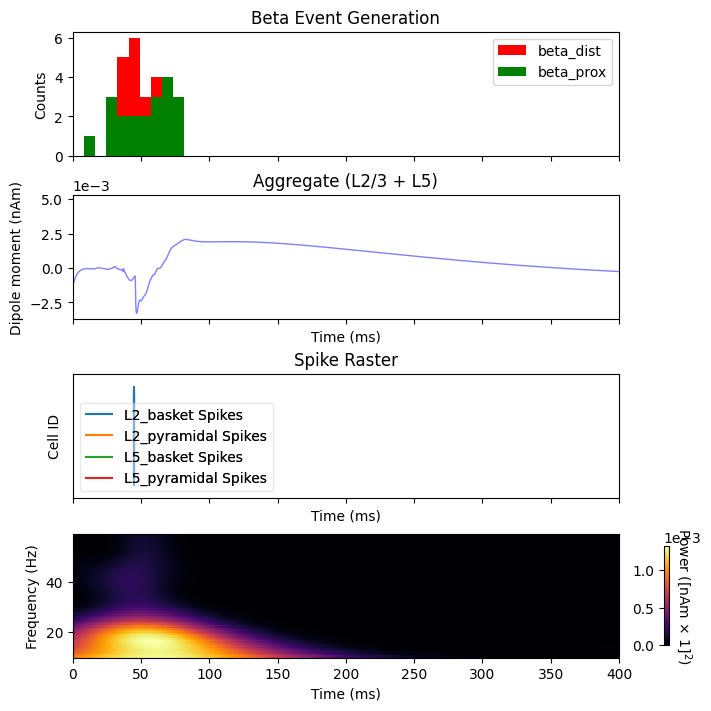

In [12]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(7, 7),
                         constrained_layout=True)
net_beta.cell_response.plot_spikes_hist(ax=axes[0], show=False)
axes[0].set_title('Beta Event Generation')
plot_dipole(dpls_beta, ax=axes[1], layer='agg', tmin=1.0, color='b', show=False)
net_beta.cell_response.plot_spikes_raster(ax=axes[2], show=False)
axes[2].set_title('Spike Raster')

# Create a fixed-step tiling of frequencies from 1 to 40 Hz in steps of 1 Hz
freqs = np.arange(10., 60., 1.)
dpls_beta[0].plot_tfr_morlet(freqs, n_cycles=7, ax=axes[3], show=False)
plt.show()

Next we will inspect what happens when a sensory stimulus is delivered 75 ms
after a beta event. Note that the delay time for a tactile stimulus at the
hand to arrive at the cortex is roughly 25 ms, which means the first proximal
input to the cortical column occurs ~100 ms after the beta event.



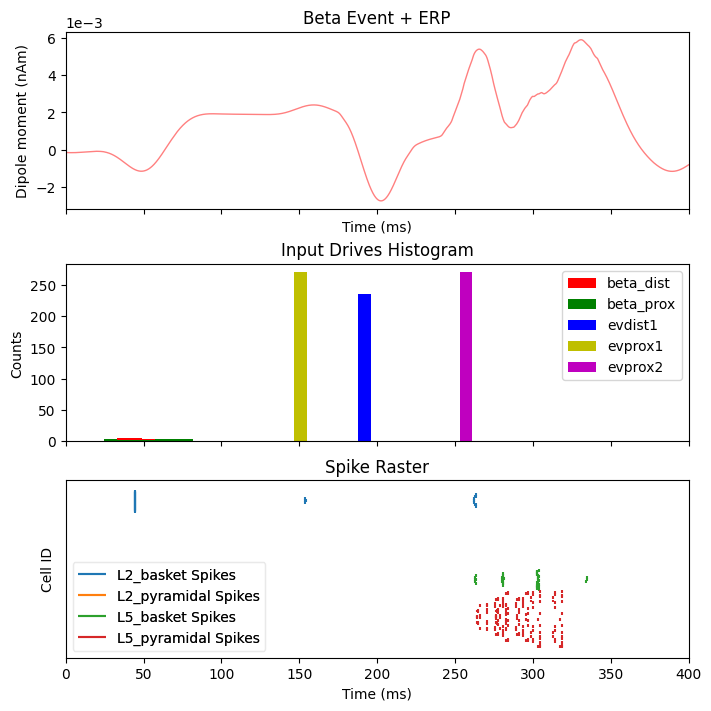

In [13]:
dpls_beta_erp[0].smooth(45)
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7, 7),
                         constrained_layout=True)
plot_dipole(dpls_beta_erp, ax=axes[0], layer='agg', tmin=1.0, color='r',
            show=False)
axes[0].set_title('Beta Event + ERP')
net_beta_erp.cell_response.plot_spikes_hist(ax=axes[1], show=False)
axes[1].set_title('Input Drives Histogram')
net_beta_erp.cell_response.plot_spikes_raster(ax=axes[2], show=False)
axes[2].set_title('Spike Raster')
plt.show()

To help understand the effect of beta mediated inhibition on the response to
incoming sensory stimuli, we can compare the ERP and spiking activity due to
sensory input with and without a beta event.
The sustained inhibition of the network ultimately depresses
the sensory response which is associated with a reduced ERP amplitude



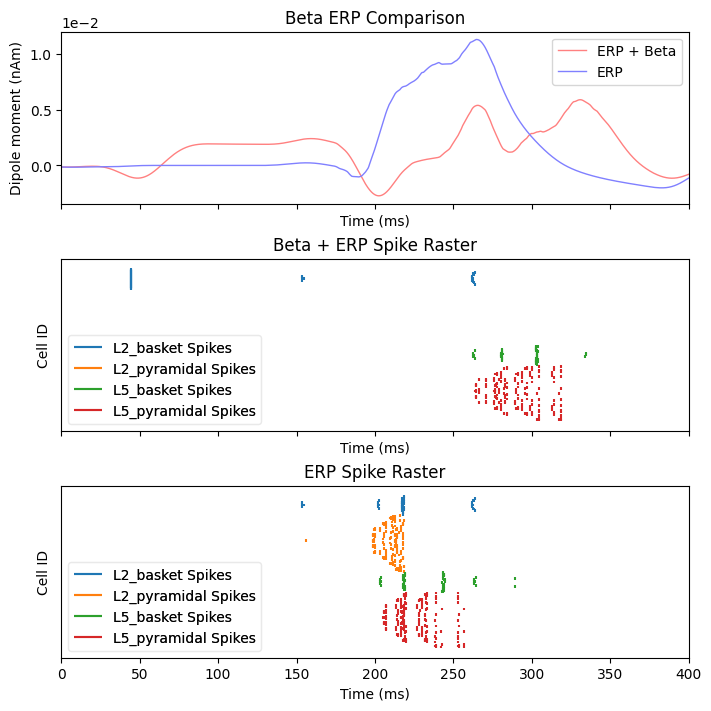

In [14]:
dpls_erp[0].smooth(45)
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7, 7),
                         constrained_layout=True)
plot_dipole(dpls_beta_erp, ax=axes[0], layer='agg', tmin=1.0, color='r',
            show=False)
plot_dipole(dpls_erp, ax=axes[0], layer='agg', tmin=1.0, color='b', show=False)
axes[0].set_title('Beta ERP Comparison')
axes[0].legend(['ERP + Beta', 'ERP'])
net_beta_erp.cell_response.plot_spikes_raster(ax=axes[1], show=False)
axes[1].set_title('Beta + ERP Spike Raster')
net_erp.cell_response.plot_spikes_raster(ax=axes[2], show=False)
axes[2].set_title('ERP Spike Raster')
plt.show()

## References

- Jones, Stephanie R., Dominique L. Pritchett, Michael A. Sikora, Steven M. Stufflebeam, Matti Hämäläinen, and Christopher I. Moore. 2009. “Quantitative Analysis and Biophysically Realistic Neural Modeling of the MEG Mu Rhythm: Rhythmogenesis and Modulation of Sensory-Evoked Responses.” Journal of Neurophysiology 102 (6): 3554–72. [https://doi.org/10.1152/jn.00535.2009](https://doi.org/10.1152/jn.00535.2009) .

- Law, Robert G., Sarah Pugliese, Hyeyoung Shin, Danielle D. Sliva, Shane Lee, Samuel Neymotin, Christopher Moore, and Stephanie R. Jones. 2021. “Thalamocortical Mechanisms Regulating the Relationship between Transient Beta Events and Human Tactile Perception.” bioRxiv. [https://doi.org/10.1101/2021.04.16.440210](https://doi.org/10.1101/2021.04.16.440210).

- Silberberg, Gilad, and Henry Markram. 2007. “Disynaptic Inhibition between Neocortical Pyramidal Cells Mediated by Martinotti Cells.” Neuron 53 (5): 735–46. [https://doi.org/10.1016/j.neuron.2007.02.012](https://doi.org/10.1016/j.neuron.2007.02.012).